# Import Libraries

In [1]:
# data wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Load data

In [2]:
df = pd.read_pickle('/Users/lau_pang/Desktop/Forage/ANZ/data.pkl')
df.head()

,status,card_present_flag,account,long_lat,txn_description,merchant_id,first_name,balance,date,gender,...,merchant_state,extraction,amount,transaction_id,customer_id,merchant_long_lat,movement,month,dayofweek,hour
0,authorized,1.0,ACC-1598451071,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,Diana,35.39,2018-08-01,F,...,QLD,01:01:15,16.25,a623070bfead4541a6b0fff8a09e706c,CUS-2487424745,153.38 -27.99,debit,8,2,01
1,authorized,0.0,ACC-1598451071,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,Diana,21.20,2018-08-01,F,...,NSW,01:13:45,14.19,13270a2a902145da9db4c951e04b51b9,CUS-2487424745,151.21 -33.87,debit,8,2,01
2,authorized,1.0,ACC-1222300524,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,Michael,5.71,2018-08-01,M,...,NSW,01:26:15,6.42,feb79e7ecd7048a5a36ec889d1a94270,CUS-2142601169,151.21 -33.87,debit,8,2,01
3,authorized,1.0,ACC-1037050564,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,Rhonda,2117.22,2018-08-01,F,...,QLD,01:38:45,40.90,2698170da3704fd981b15e64a006079e,CUS-1614226872,153.05 -26.68,debit,8,2,01
4,authorized,1.0,ACC-1598451071,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,Diana,17.95,2018-08-01,F,...,QLD,01:51:15,3.25,329adf79878c4cf0aeb4188b4691c266,CUS-2487424745,153.44 -28.06,debit,8,2,01


In [3]:
pd.DataFrame({'columns': df.columns})

,columns
0,status
1,card_present_flag
2,account
3,long_lat
4,txn_description
5,merchant_id
6,first_name
7,balance
8,date
9,gender


# Feature Engineering

## Target Variable (annual salary)

In [4]:
df['txn_description'].value_counts()

SALES-POS     3934
POS           3783
PAYMENT       2600
PAY/SALARY     883
INTER BANK     742
PHONE BANK     101
Name: txn_description, dtype: int64

In [5]:
# Check the salary payment frequency of each customer
salary_df = pd.DataFrame({"customer_id": df.customer_id.unique()})
salary_df.head()

,customer_id
0,CUS-2487424745
1,CUS-2142601169
2,CUS-1614226872
3,CUS-2688605418
4,CUS-4123612273


In [6]:
# Loop through all salary payments for each customer
# Assume the salary level is constant for each customer over the observed period
df_freq = []
df_amount = []

for customer in range(len(salary_df)):
    salary = df.loc[(df.customer_id == salary_df.customer_id[customer]) & (df.txn_description == "PAY/SALARY"), ["date", "amount"]].groupby("date", as_index = False).sum()
    count = len(salary)
    if count == 0:
        df_amount.append(np.nan)
        df_freq.append(np.nan)
    else:
        days_between_payments = []
        for date in range(len(salary)-1):
            days_between_payments.append((salary.date[date + 1] - salary.date[date]).days)
        df_freq.append(max(days_between_payments))
        df_amount.append(mode(salary.amount))

salary_df["salary_freq"] = df_freq
salary_df["salary_amount"] = df_amount       
salary_df["annual_salary"] = salary_df["salary_amount"] / salary_df["salary_freq"] * 365
salary_df.head()

,customer_id,salary_freq,salary_amount,annual_salary
0,CUS-2487424745,7,1013.67,52855.650000
1,CUS-2142601169,7,1002.13,52253.921429
2,CUS-1614226872,7,892.09,46516.121429
3,CUS-2688605418,14,2320.30,60493.535714
4,CUS-4123612273,7,1068.04,55690.657143


<Figure size 720x360 with 0 Axes>

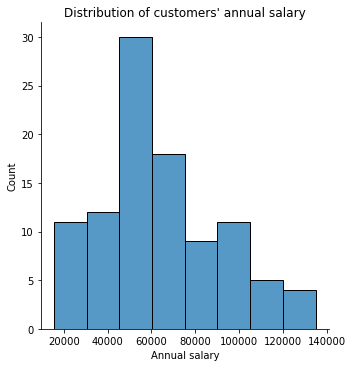

In [7]:
# Plot customer's annual salary distribution 

plt.figure(figsize = (10, 5))
sns.displot(salary_df.annual_salary)
plt.title("Distribution of customers' annual salary")
plt.xlabel("Annual salary");

## Independent Variables

- balance
- gender
- age
- average weekly transaction frequency
- average transaction amount

In [8]:
# Unique customer id's 

unique_id = df.customer_id.unique()
len(unique_id)

100

### Average weekly transaction frequency

In [9]:
avg_weekly_tran_freq = []
for c_id in unique_id:
    array = df.loc[df.customer_id == c_id, "date"]
    avg_weekly_tran_freq.append(round(len(array)/array.nunique()*7))
avg_weekly_tran_freq[:5]

[48, 29, 24, 14, 21]

### Average transaction amount

In [10]:
avg_trans_amount = []
for c_id in unique_id:
    array = df.loc[df.customer_id == c_id, "amount"]
    avg_trans_amount.append(array.mean())
avg_trans_amount[:5]

[45.34877162629756,
 78.20610561056101,
 74.46501930501928,
 159.3041860465116,
 166.50835820895517]

### Median balance

In [11]:
median_balance = []
for c_id in unique_id:
    array = df.loc[df.customer_id == c_id, "balance"]
    median_balance.append(array.median())
median_balance[:5]

[1580.4, 1132.66, 3618.5, 5616.63, 6162.45]

### State

In [12]:
state = []
for c_id in unique_id:
    array = df.loc[df.customer_id == c_id, "merchant_state"]
    state.append(mode(array))
state[:5]

['QLD', 'NSW', 'QLD', 'NSW', 'VIC']

### Age

In [13]:
age = []
for c_id in unique_id:
    array = df.loc[df.customer_id == c_id, "age"]
    age.append(mode(array))
age[:5]

[26, 38, 40, 20, 43]

### Gender

In [14]:
gender = []
for c_id in unique_id:
    array = df.loc[df.customer_id == c_id, "gender"]
    gender.append(mode(array))
gender[:5]

['F', 'M', 'F', 'M', 'F']

### Put everything together

In [15]:
# Independent variables 

features_df = pd.DataFrame({"customer_id": unique_id, 
                            "avg_weekly_tran_freq": avg_weekly_tran_freq, 
                            "avg_trans_amount": avg_trans_amount,
                            "median_balance": median_balance, 
                            "state": state,
                            "age": age,
                            "gender": gender})
features_df.head()

,customer_id,avg_weekly_tran_freq,avg_trans_amount,median_balance,state,age,gender
0,CUS-2487424745,48,45.348772,1580.40,QLD,26,F
1,CUS-2142601169,29,78.206106,1132.66,NSW,38,M
2,CUS-1614226872,24,74.465019,3618.50,QLD,40,F
3,CUS-2688605418,14,159.304186,5616.63,NSW,20,M
4,CUS-4123612273,21,166.508358,6162.45,VIC,43,F


In [16]:
salary_df.head()

,customer_id,salary_freq,salary_amount,annual_salary
0,CUS-2487424745,7,1013.67,52855.650000
1,CUS-2142601169,7,1002.13,52253.921429
2,CUS-1614226872,7,892.09,46516.121429
3,CUS-2688605418,14,2320.30,60493.535714
4,CUS-4123612273,7,1068.04,55690.657143


In [17]:
df1 = pd.concat([features_df, salary_df['annual_salary']], axis = 1)
df1.head()

,customer_id,avg_weekly_tran_freq,avg_trans_amount,median_balance,state,age,gender,annual_salary
0,CUS-2487424745,48,45.348772,1580.40,QLD,26,F,52855.650000
1,CUS-2142601169,29,78.206106,1132.66,NSW,38,M,52253.921429
2,CUS-1614226872,24,74.465019,3618.50,QLD,40,F,46516.121429
3,CUS-2688605418,14,159.304186,5616.63,NSW,20,M,60493.535714
4,CUS-4123612273,21,166.508358,6162.45,VIC,43,F,55690.657143


# Preprocessing

## Train test set split

In [18]:
X = df1.drop(["customer_id", "annual_salary"], axis = 1)
Y = df1.annual_salary
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

X shape:  (100, 6)
Y shape:  (100,)


In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape:  (70, 6)
Y_train shape:  (70,)
X_test shape:  (30, 6)
Y_test shape:  (30,)


## Column transformer

In [20]:
# Crete column transformer 
ohe = OneHotEncoder(sparse = False)
scaler = StandardScaler()
column_transform = make_column_transformer((ohe, ["state", "gender"]), 
                                           (scaler, ["avg_weekly_tran_freq", "avg_trans_amount", "median_balance", "age"]))

# Modelling

- linear regression
- decision tree

## Linear Regression

In [21]:
# Instantiate model and pipeline

model1 = LinearRegression()
model1_pipeline = make_pipeline(column_transform, model1)

In [22]:
# Fit pipeline and make predictions 

model1_pipeline.fit(X_train, Y_train)
model1_pred = model1_pipeline.predict(X_test)

In [23]:
# RMSE

print("RMSE: ", round(np.sqrt(mean_squared_error(model1_pred, Y_test))))

RMSE:  36046


## Decision Tree

In [24]:
# Instantiate model and pipeline 

model2 = DecisionTreeRegressor()
model2_pipeline = make_pipeline(column_transform, model2)

In [25]:
# Fit pipeline and make predictions 

model2_pipeline.fit(X_train, Y_train)
model2_pred = model2_pipeline.predict(X_test)

In [26]:
# RMSE 

print("RMSE: ", round(np.sqrt(mean_squared_error(model2_pred, Y_test))))

RMSE:  21681


# Conclusion

- both models appear to be highly inaccurate, but decision tree performed relatively more accurate than linear regression.
- In order to make the prediction more accurate, it is suggested to gather more data as the 100 customer records is fairly small. 